Pytorch installation.

In [0]:
!pip3 install torch

Import all the libraries for this project.

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

Test cuda_gpu

In [0]:
torch.cuda.is_available()

True

Define global variable.

In [0]:
column_names = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed = 7
np.random.seed(seed)

num_epochs = 200
num_features = 3
num_classes = 18
batch_size = 100
learning_rate = 0.001

# parameters
segment_time_size = 200
time_step = 100
hidden_size = 30
num_lstm_layers = 2

Combining all files of accelerator data that on the phone, I create a new .txt file that gives all the information among users. Then load the new file as dataset and remove semicolons as well.

In [0]:
"""
path='/Users/Adamyae/Downloads/wisdm-dataset/raw/phone/accel'
# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/phone/gyro'
# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/watch/accel'
# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/watch/gyro'
filelist = os.listdir(path)
with io.open('/Users/Adamyae/Downloads/wisdm-dataset/raw/raw.txt', 'a+', encoding='utf-8', errors='ignore') as f:
    for filename in filelist:
        filepath = path+'/'+filename
        for line in io.open(filepath, encoding='utf-8', errors='ignore'):
            f.writelines(line)
    f.close()
"""

"\npath='/Users/Adamyae/Downloads/wisdm-dataset/raw/phone/accel'\n# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/phone/gyro'\n# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/watch/accel'\n# path='/Users/Adamyae/Downloads/wisdm-dataset/raw/watch/gyro'\nfilelist = os.listdir(path)\nwith io.open('/Users/Adamyae/Downloads/wisdm-dataset/raw/raw.txt', 'a+', encoding='utf-8', errors='ignore') as f:\n    for filename in filelist:\n        filepath = path+'/'+filename\n        for line in io.open(filepath, encoding='utf-8', errors='ignore'):\n            f.writelines(line)\n    f.close()\n"

Initialize data and remove semicolon from z-axis

In [0]:
data = pd.read_csv('raw.txt',header=None,names=column_names)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
print(data.shape)

(227661, 6)


Data preprocessing for LSTM.

In [0]:
data_convoluted = []
labels = []

# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - segment_time_size, time_step):
    x = data['x-axis'].values[i: i + segment_time_size]
    y = data['y-axis'].values[i: i + segment_time_size]
    z = data['z-axis'].values[i: i + segment_time_size]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + segment_time_size])[0][0]
    labels.append(label)

# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# Encode labels (cross entropy loss takes labels, not one-hot [mathematically same])
encoded_labels = LabelEncoder().fit_transform(labels)

print(data_convoluted.shape)

(2275, 200, 3)


Data Visualization.

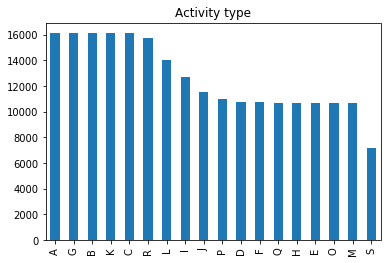

In [0]:
# SHOW ACTIVITY GRAPH
activity_type = data['activity'].value_counts().plot(kind='bar', title='Activity type')
plt.show()

Dataloader and Model definition.

In [0]:
class wisdmDataset(object):
    
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
            return len(self.data)
        
    def __getitem__(self, index):
        features = self.data[index]
        label = self.labels[index]
        
        if self.transform is not None:
            features = self.transform(features)
        
        features = features.astype(np.float32)
        
        return torch.Tensor(features), label
    
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_lstm_layers, num_classes):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

#Convolutional neural network
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 128, kernel_size=8, padding=0)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=0)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=0)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.adaptive_avg_pool2d(out, (128,1))
        out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.log_softmax(out, dim=1)
        return out

Model creation and training.

In [0]:
# Model and dataloader creation
model = RNN(num_features, hidden_size, num_lstm_layers, num_classes).to(device)
# model = CNN(num_classes).to(device)
# Split data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(data_convoluted, encoded_labels, test_size=0.2, random_state=seed)
print("X train size: ", len(X_train))
print("X test size: ", len(X_test))
print("y train size: ", len(y_train))
print("y test size: ", len(y_test))

#X_train = X_train.reshape(-1,3,200)
#X_test = X_test.reshape(-1,3,200)


train_dataset = wisdmDataset(X_train, y_train, transform=None)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = wisdmDataset(X_test, y_test, transform=None)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Loss and optimizer definition

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model


total_step = len(train_loader)
history_loss = []
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader): 
        
        features = features.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        
        #Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            history_loss.append(loss.item)

X train size:  125042
X test size:  31261
y train size:  125042
y test size:  31261
Epoch [1/200], Step [5/1251], Loss: 2.9179
Epoch [1/200], Step [10/1251], Loss: 2.9042
Epoch [1/200], Step [15/1251], Loss: 2.8828
Epoch [1/200], Step [20/1251], Loss: 2.8668
Epoch [1/200], Step [25/1251], Loss: 2.8969
Epoch [1/200], Step [30/1251], Loss: 2.8949
Epoch [1/200], Step [35/1251], Loss: 2.8809
Epoch [1/200], Step [40/1251], Loss: 2.8609
Epoch [1/200], Step [45/1251], Loss: 2.8711
Epoch [1/200], Step [50/1251], Loss: 2.8787
Epoch [1/200], Step [55/1251], Loss: 2.8627
Epoch [1/200], Step [60/1251], Loss: 2.8623
Epoch [1/200], Step [65/1251], Loss: 2.8187
Epoch [1/200], Step [70/1251], Loss: 2.8060
Epoch [1/200], Step [75/1251], Loss: 2.8047
Epoch [1/200], Step [80/1251], Loss: 2.8169
Epoch [1/200], Step [85/1251], Loss: 2.8030
Epoch [1/200], Step [90/1251], Loss: 2.8046
Epoch [1/200], Step [95/1251], Loss: 2.8123
Epoch [1/200], Step [100/1251], Loss: 2.7824
Epoch [1/200], Step [105/1251], Loss

Verification testing of the model

In [0]:
# Test the model

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for features, labels in test_loader:
        
        features = features.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # Forward pass
        
        outputs = model(features)
        _, predicted = torch.max(outputs.data , 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the data in the test_loader: {} %'.format(100 * correct / total))

NameError: ignored